# Making Predictions On A Single Image

In [1]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device='cpu'

In [3]:
image_paths = './images/*/*/*'
image_paths = glob(image_paths)

In [4]:
image_paths

['./images/og/cataract/preprocessed_cataract_015_png.rf.1b6efc1c6e942794c60026a935a0b173.jpg',
 './images/og/cataract/preprocessed_cataract_077_png.rf.1eb48e0904c15715f7a81b74d60e286d.jpg',
 './images/og/cataract/preprocessed_cataract_022_png.rf.82f3ffab2f106292004f95b38ef58c5a.jpg',
 './images/og/cataract/preprocessed_cataract_031_png.rf.3ce9ad8a18690d282b4271838a5d0f5c.jpg',
 './images/og/cataract/preprocessed_cataract_083_png.rf.5db44cb76795c508ac5ecc5c2a863d45.jpg',
 './images/og/cataract/preprocessed_cataract_055_png.rf.c6cb54e1f5700e738273a59ed23f32e1.jpg',
 './images/og/cataract/preprocessed_cataract_039_png.rf.5018f8456431131c2f960dc97ace70ed.jpg',
 './images/og/cataract/_4_7491150_jpg.rf.a98dfd942479cae97b6d8dc440aec598.jpg',
 './images/og/cataract/preprocessed_cataract_029_png.rf.0575d12060432d68553dd8c773d39083.jpg',
 './images/og/cataract/preprocessed_cataract_045_png.rf.eb08931ec28f929eff63f1e4b964d929.jpg',
 './images/og/cataract/preprocessed_cataract_053_png.rf.9ae19cfff

In [5]:
len(image_paths)

50575

In [6]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[3]
    image = image_path.split(os.path.sep)[4]
    labels.append(label)
    images.append(image)

In [7]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 2)))
pred2label = dict(zip(range(0, 2), np.unique(labels)))
n_classes = len(np.unique(labels))

In [8]:
n_classes

2

In [9]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)          
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [10]:
class EfficientNetB3(ClassificationBase):

    def __init__(self):
        super().__init__()

        self.network = timm.create_model('efficientnet_b3', pretrained=True)
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, n_classes)


    def forward(self, batch):
        batch = batch.to(device)
        return torch.sigmoid(self.network(batch))


model = EfficientNetB3()
model = torch.compile(model)

Process ForkProcess-8:
Process ForkProcess-7:
Process ForkProcess-6:
Process ForkProcess-5:
Process ForkProcess-4:
Process ForkProcess-1:
Process ForkProcess-3:
Process ForkProcess-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):

In [11]:
model = model.to(device)

In [12]:
model.load_state_dict(torch.load('model_0.99.pth', map_location=torch.device('cpu')))
model.eval()

OptimizedModule(
  (_orig_mod): EfficientNetB3(
    (network): EfficientNet(
      (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=Fal

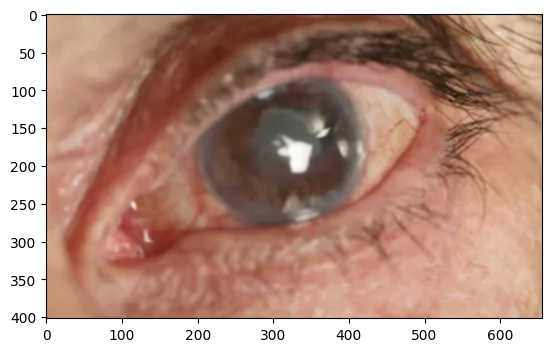

In [16]:
image = cv2.imread('./cataract.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [17]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((300, 300)),
])

image = test_transforms(image)
image = torch.reshape(image, (1, 3, 300, 300))

/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
model.eval()
pred2label[np.argmax(model(image).cpu().detach().numpy())]

'cataract'